In [78]:
import pymolpro
import pandas as pd

In [79]:
backend = 'local' 
project_name = 'BH76_methodtest'
parallel = 8

In [80]:
methods = {"HF": "hf",
"MP2": "mp2",
"MP3": "mp3",
"MP4": "mp4",
"PAPT2":"PAPT;MP2",
"PAPT3":"PAPT;MP3",
"PAPT4":"PAPT;MP4",
"CCSD":"CCSD",
"CCSD(T)":"CCSD(T)" }
bases = ['cc-pVDZ','cc-pVTZ']

In [81]:
db = pymolpro.database.load("GMTKN55_BH76")

In [82]:
small=db.subset(open_shell=False,max_electrons=30)
print(small)

GMTKN55 BH76 (closed shell only) (maximum number of electrons 30):

Molecules:
ch3f: {'geometry': '           5\n  \n    C          0.00000000      0.00000000      0.06556637\n    F          0.00000000      0.00000000     -1.31562859\n    H          0.51491633     -0.89186125      0.41668741\n    H          0.51491633      0.89186125      0.41668741\n    H         -1.02983267      0.00000000      0.41668741\n', 'description': 'ch3f'}
fch3fcomp: {'geometry': '           6\n  \n    F          0.00000000      0.00000000     -1.79137135\n    C          0.00000000      0.00000000     -0.36561703\n    H         -0.51179113      0.88644824     -0.01758668\n    H         -0.51179113     -0.88644824     -0.01758668\n    H          1.02358226      0.00000000     -0.01758668\n    F          0.00000000      0.00000000      2.20974841\n', 'description': 'fch3fcomp', 'charge': -1}
fch3fts: {'geometry': '           6\n  \n    F          1.82355879      0.00051927      0.00010874\n    C          0.000

In [83]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(small, methods[method], basis, location=project_name,
                                                       backend=backend,
                                                       preamble="core,small", parallel=parallel)
        if results[method][basis].failed: print(method, basis, 'failed', results[method][basis].project_directory)
        
print(results)    

{'HF': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f8eb646f910>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f8eb646e350>}, 'MP2': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f8eb646ce80>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f8eb646c9d0>}, 'MP3': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f8eb646fd60>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f8eb646d6f0>}, 'MP4': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f8f116ff400>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f8ebf44fd60>}, 'PAPT2': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f8eb64cf130>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f8eb6df7730>}, 'PAPT3': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f8ec7ed74c0>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f8ebf4504f0>}, 'PAPT4': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f8eb645fa60>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f8eb6c41ae0>}, 'CCSD':

In [84]:
analyse=pymolpro.database.analyse([result['cc-pVTZ'] for result in results.values()],small)
analyse['reaction statistics']

,HF/cc-pVTZ,MP2/cc-pVTZ,MP3/cc-pVTZ,MP4/cc-pVTZ,PAPT;MP2/cc-pVTZ,PAPT;MP3/cc-pVTZ,PAPT;MP4/cc-pVTZ,CCSD/cc-pVTZ,CCSD(T)/cc-pVTZ
MAD,0.006212,0.008084,0.005266,0.009312,0.005371,0.005375,0.006716,0.005618,0.007548
MAXD,0.012808,0.015859,0.013608,0.018357,0.012308,0.012325,0.014324,0.010992,0.015926
RMSD,0.007084,0.009585,0.006171,0.011399,0.006242,0.006240,0.008643,0.006836,0.009574
MSD,0.006035,-0.004139,0.000817,-0.007468,-0.000010,0.000016,-0.004581,-0.002366,-0.005856
STDEVD,0.003912,0.009112,0.006448,0.009078,0.006579,0.006578,0.007726,0.006761,0.007984


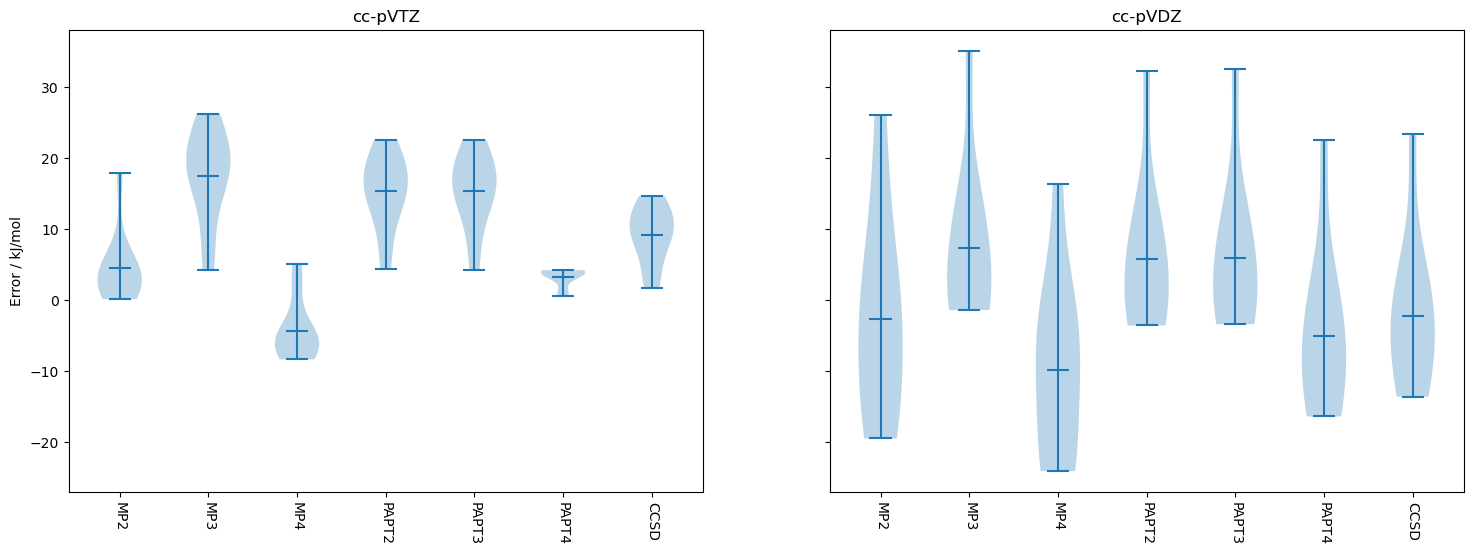

In [88]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if (method != 'HF') and (method != 'CCSD(T)')]
bases_pruned = ['cc-pVTZ', 'cc-pVDZ']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                      results['CCSD(T)']['cc-pVTZ'],'kJ/mol')['reaction energy deviations'].to_numpy()[:, 0]
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")
df = pd.DataFrame(data)
df.to_excel("PAPT.xlsx")

In [87]:
extrapolate=pymolpro.database.basis_extrapolate(results[method].values(), results["HF"].values())
extrapolate